In [2]:
import scipy.io, os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from fastjmd95 import rho
from matplotlib.colors import ListedColormap
import seaborn as sns; sns.set()
sns.set()
import seawater as sw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes        
import matplotlib as mpl

colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)

color_list=colours

In [2]:
!pip install seaborn


     |████████████████████████████████| 285 kB 6.3 MB/s eta 0:00:01


## Code to plot the meridional overturning and density structure from the North Atlantic from Sonnewald and Lguensat (2021).

Data used are from the ECCOv4 State Estimate available: https://ecco-group.org/products-ECCO-V4r4.html

Note: Data is generated for the North Atlantic, also including the Southern Ocean and Artcic basin. Data fro the Paciic and Indian ocean are also generated, and the bleow code can be adjusted to plot this also.


In [3]:
gridInfo=Dataset('/home/jovyan/DNN4Cli/figures/IPSL/gridInfoIPSL.nc')
zLev=gridInfo['deptho'][:]
depthPlot=zLev.cumsum()
lat=gridInfo['nav_lat'][:]
lon=gridInfo['nav_lon'][:]

In [ ]:
zMat=np.repeat(zLev,720*360).reshape((50,360,720))

dvx=np.rot90(0.5*111000*np.cos(lat*(np.pi/180)),1)

masks=np.load('regimeMasks.npz')
maskMD=masks['maskMD']
maskSSV=masks['maskSSV']
maskNSV=masks['maskNSV']
maskTR=masks['maskTR']
maskSO=masks['maskSO']
maskNL=masks['maskNL']

In [4]:
def getData(NR):
    arr = os.listdir('/home/maike/Documents/ECCO_BV/NVELSTAR/.')
    f =Dataset('/home/maike/Documents/ECCO_BV/NVELSTAR/'+arr[NR])
    nvelS =f.variables['NVELSTAR'][:]

    arr = os.listdir('/home/maike/Documents/ECCO_BV/NVELMASS/.')
    f =Dataset('/home/maike/Documents/ECCO_BV/NVELMASS/'+arr[NR])
    nvelM =f.variables['NVELMASS'][:]

    return(nvelS+nvelM)

## Creating the basin masks

In [6]:
nvel= getData(1) #To get the shape

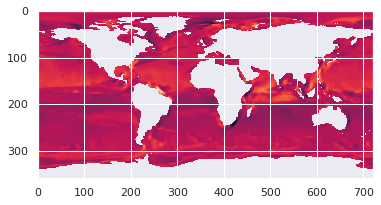

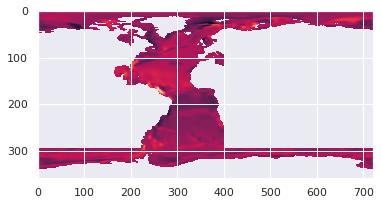

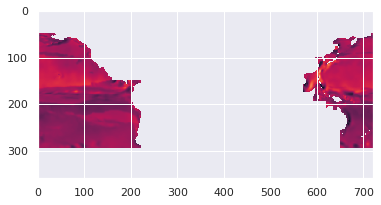

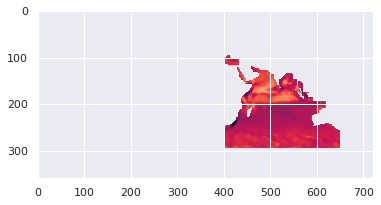

In [9]:
globalMask=np.ones(nvel[0].shape)

maskArea=np.zeros(nvel[0].shape)*np.nan
maskArea[:,65:360,0:222]=1
maskArea[:,65:360,500:720]=1
maskArea[:,310:360,:]=np.nan
maskArea[:,210:350,160:250]=np.nan
maskArea[:,0:140,500:650]=np.nan
maskArea[:,0:165,500:620]=np.nan
maskArea[:,0:255,500:560]=np.nan
maskArea[:,0:210,500:570]=np.nan
maskArea[:,0:185,500:590]=np.nan
pacificMask=maskArea

maskArea=np.zeros(nvel[0].shape)*np.nan
maskArea[:,:,221:400]=1
maskArea[:,200:360,160:400]=1
maskArea[:,0:65,:]=1
maskArea[:,310:360,:]=1
maskArea[:,199:215,160:180]=np.nan
maskArea[:,199:210,160:190]=np.nan
atlanticMask=maskArea

maskArea=np.ones(nvel[0].shape)
indA=np.where(atlanticMask==1)
indP=np.where(pacificMask==1)
maskArea[indA]=np.nan
maskArea[indP]=np.nan
maskArea[:,100:250,100:250]=np.nan
indianMask=maskArea

plt.figure()
plt.imshow(np.flipud(globalMask[0]*nvel[0,0]))
plt.figure()
plt.imshow(np.flipud(atlanticMask[0]*nvel[0,0]))
plt.figure()
plt.imshow(np.flipud(pacificMask[0]*nvel[0,0]))
plt.figure()
plt.imshow(np.flipud(indianMask[0]*nvel[0,0]))

## Calculating the streamfunction

The overall meridional overturning ($\Psi_{z\theta}$) from Fig. 3 in Sonnewald and Lguensat (2021) is defined as:

$$\Psi_{z\theta}(\theta,z)=- \int^z_{-H} \int_{\phi_2}^{\phi_1} v(\phi,\theta,z')d\phi dz',$$

\noindent where $z$ is the relative level depth and $v$ is the meridional (north-south) component of velocity. For the regimes, the relevant velocity fields were then used. A positive $\Psi_{z\theta}$ signifies a clockwise circulation, while a negative $\Psi_{z\theta}$ signifies an anticlockwise circulation.

In [9]:
def psiZ(NVEL_IN, mask):
    '''Function to calculate overturning in depth space as described in Sonnewald and Lguensat (2021).'''
    ntrans=np.zeros(NVEL_IN[:,:,0].shape);
    gmoc=np.zeros(NVEL_IN[:,:,0].shape);
    NVEL=NVEL_IN*mask

    # zonal transport integral
    for zz in np.arange(0,50):
        ntrans[zz,:]=np.nansum(NVEL[zz,:,:]*dvx,axis=1); 

    for zz in np.flipud(np.arange(0,49)):
        gmoc[zz,:]=gmoc[zz+1,:]+ntrans[zz+1,:]*zLev[zz+1];

    gmoc=gmoc/1e6; 
    return(gmoc)

In [10]:
def psiMaskedCalc(mask):
    '''Calculating the overturning in depth space for the different regimes, as plotted in Fig. 3 in Sonnewald and Lguensat (2021).'''
    yrs, months=20,12

    PSI_all = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_NL = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_SO = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_SSV = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_NSV = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_MD = np.zeros((yrs*months, 50, 360))*np.nan
    PSI_TR = np.zeros((yrs*months, 50, 360))*np.nan

    ITTER=0
    for NR in np.arange(0,yrs):
        nvel= getData(NR)
       # print('Got data')
        for MM in np.arange(0,months):
            PSI_all[ITTER]=psiZ(nvel[MM], np.ones(maskSO.shape)*mask)
            PSI_NL[ITTER]=psiZ(nvel[MM], maskNL*mask)
            PSI_SO[ITTER]=psiZ(nvel[MM], maskSO*mask)
            PSI_SSV[ITTER]=psiZ(nvel[MM], maskSSV*mask)
            PSI_NSV[ITTER]=psiZ(nvel[MM], maskNSV*mask)
            PSI_MD[ITTER]=psiZ(nvel[MM], maskMD*mask)
            PSI_TR[ITTER]=psiZ(nvel[MM], maskTR*mask)
            ITTER+=1                   
    return PSI_all, PSI_NL, PSI_SO, PSI_SSV, PSI_NSV, PSI_MD, PSI_TR

In [20]:
PSI_all_A, PSI_NL_A, PSI_SO_A, PSI_SSV_A, PSI_NSV_A, PSI_MD_A, PSI_TR_A = psiMaskedCalc(atlanticMask)

PSI_all_P, PSI_NL_P, PSI_SO_P, PSI_SSV_P, PSI_NSV_P, PSI_MD_P, PSI_TR_P = psiMaskedCalc(pacificMask)

PSI_all_I, PSI_NL_I, PSI_SO_I, PSI_SSV_I, PSI_NSV_I, PSI_MD_I, PSI_TR_I = psiMaskedCalc(indianMask)

PSI_all_G, PSI_NL_G, PSI_SO_G, PSI_SSV_G, PSI_NSV_G, PSI_MD_G, PSI_TR_G = psiMaskedCalc(globalMask)



In [22]:
#Save the data

np.savez('PSI_global', PSI_all_G=PSI_all_G, PSI_NL_G=PSI_NL_G, PSI_SO_G=PSI_SO_G, PSI_SSV_G=PSI_SSV_G, PSI_NSV_G=PSI_NSV_G,  PSI_MD_G=PSI_MD_G, PSI_TR_G=PSI_TR_G)

np.savez('PSI_atlantic', PSI_all_A=PSI_all_A, PSI_NL_A=PSI_NL_A, PSI_SO_A=PSI_SO_A, PSI_SSV_A=PSI_SSV_A, PSI_NSV_A=PSI_NSV_A,  PSI_MD_A=PSI_MD_A, PSI_TR_A=PSI_TR_A)

np.savez('PSI_pacific', PSI_all_P=PSI_all_P, PSI_NL_P=PSI_NL_P, PSI_SO_P=PSI_SO_P, PSI_SSV_P=PSI_SSV_P, PSI_NSV_P=PSI_NSV_P,  PSI_MD_P=PSI_MD_P, PSI_TR_P=PSI_TR_P)

np.savez('PSI_indian',  PSI_all_I=PSI_all_I, PSI_NL_I=PSI_NL_I, PSI_SO_I=PSI_SO_I, PSI_SSV_I=PSI_SSV_I, PSI_NSV_I=PSI_NSV_I,  PSI_MD_I=PSI_MD_I, PSI_TR_I=PSI_TR_I)

## Calculate the density in $\sigma_2$

In [10]:
def getDataTS(NR):
    '''Retrieve the T and S data. Data from the ECCOv4 state estimate.'''
    arr = os.listdir('/home/maike/Documents/ECCO_BV/THETA/.')
    f =Dataset('/home/maike/Documents/ECCO_BV/THETA/'+arr[NR])
    T =f.variables['THETA'][:]

    arr = os.listdir('/home/maike/Documents/ECCO_BV/SALT/.')
    f =Dataset('/home/maike/Documents/ECCO_BV/SALT/'+arr[NR])
    S =f.variables['SALT'][:]

    return(T, S)

In [14]:
dens=np.zeros((50,360,720))
ITTER=1
yrs=20
months=12
for NR in np.arange(0,yrs):
    T,S = getDataTS(NR)
    print('Got data', NR)
    #Tin=sw.eos80.temp(S, T, -np.cumsum(zMat, axis=0), pr=np.cumsum(zMat, axis=0))
    for MM in np.arange(0,months):
        dens = dens+rho(S[MM], T[MM], 2000) - 1000
        ITTER+=1
dens=dens/ITTER

Got data 0
Got data 1
Got data 2
Got data 3
Got data 4
Got data 5
Got data 6
Got data 7
Got data 8
Got data 9
Got data 10
Got data 11
Got data 12
Got data 13
Got data 14
Got data 15
Got data 16
Got data 17
Got data 18
Got data 19


In [16]:
#Save the density data.
np.save('density20yr', np.array(dens))

# Finally, we plot the data.

The plot is a composite of different subplots.


In [11]:

levs=[32,33,34, 34.5, 35, 35.5,36,36.5,37,37.25,37.5,37.75,38]
cols=plt.cm.viridis([300,250, 200,150, 125, 100, 50,30, 10,15,10,9,1])
Land=np.ones(np.nansum(PSI_all_A, axis=0).shape)*np.nan
Land[np.nansum(PSI_all_A, axis=0)==0.0]=0
land3D=np.ones(dens.shape)
land3D[dens==0]=np.nan

def zPlotSurf(ax, data,zMin, zMax,label,mm,latMin,latMax,RGB,Ticks,saveName='test'):
    land=np.ones(np.nanmean(data, axis=0).shape)*np.nan
    land[np.nansum(data, axis=0)==0.0]=0
    n=50
    levels = np.linspace(-20, 20, n+1)
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],-np.nanmean(data, axis=0)[zMin:zMax,latMin:latMax], levels=np.linspace(-20, 20, n+1),cmap=plt.cm.seismic, extend='both')

    n2=30  
    densityPlot=np.nanmean((dens*land3D*mm), axis=2)
    assert(len(levs)==len(cols))
    CS=ax.contour(lat[0,latMin:latMax],-depthPlot[zMin:zMax],densityPlot[zMin:zMax,latMin:latMax],
                  levels=levs,
                  linewidths=3,colors=cols, extend='both')

    ax.tick_params(axis='y', labelsize=20)
    if Ticks == 0:
        ax.set_xticklabels( () )
    elif Ticks == 1:
        ax.set_xticklabels( () )
        ax.set_yticklabels( () )
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],land[zMin:zMax,latMin:latMax], 1,cmap=plt.cm.Set2)
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],Land[zMin:zMax,latMin:latMax], 50,cmap=plt.cm.bone)

    yL=ax.get_ylim()
    xL=ax.get_xlim()
    plt.text(xL[0]+0.02*np.ptp(xL), yL[0]+0.4*np.ptp(yL), label, fontsize=20, size=30, 
             weight='bold', bbox={'facecolor':'white', 'alpha':0.7}, va='bottom')
    
    
def zPlotDepth(ax, data,zMin, zMax,label,mm,latMin,latMax,RGB,Ticks,saveName='test'):
    land=np.ones(np.nanmean(data, axis=0).shape)*np.nan
    land[np.nansum(data, axis=0)==0.0]=0
    n=50
    levels = np.linspace(-20, 20, n+1)
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],-np.nanmean(data, axis=0)[zMin:zMax,latMin:latMax], levels=np.linspace(-20, 20, n+1),cmap=plt.cm.seismic, extend='both')
    n2=30
    densityPlot=np.nanmean((dens*land3D*mm), axis=2)
    ax.contour(lat[0,latMin:latMax],-depthPlot[zMin:zMax],densityPlot[zMin:zMax,latMin:latMax], colors=cols,
               levels=levs,
               linewidths=3, extend='both')

    if Ticks == 0:
        ax.tick_params(axis='y', labelsize=20)
        #ax.set_xticklabels( () )
    elif Ticks== 1:
        #ax.set_xticklabels( () )
        ax.set_yticklabels( () )
    plt.tick_params(axis='both', labelsize=20)
    #plt.clim(cmin, cmax)
    
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],land[zMin:zMax,latMin:latMax], 1,cmap=plt.cm.Set2)
    ax.contourf(lat[0,latMin:latMax],-depthPlot[zMin:zMax],Land[zMin:zMax,latMin:latMax], 50,cmap=plt.cm.bone)
    yL=ax.get_ylim()
    xL=ax.get_xlim()
    plt.text(xL[0]+0.03*np.ptp(xL), yL[0]+0.03*np.ptp(yL), label, fontsize=20, size=30, 
             weight='bold', bbox={'facecolor':RGB, 'alpha':1}, va='bottom')
    


/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
/home/maike/Downlo

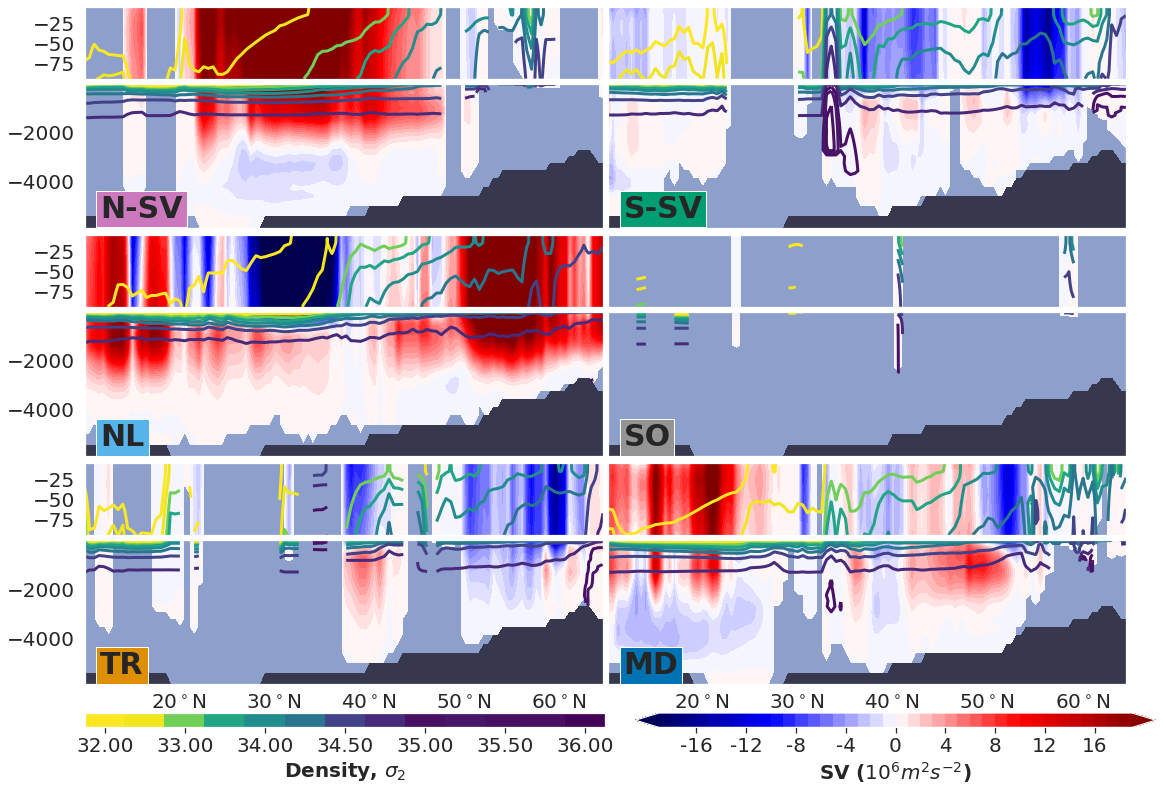

In [12]:
# Set general figure options

# figure layout
xs = 15.5     # figure width in inches
nx = 2       # number of axes in x dimension
ny = 3     # number of sub-figures in y dimension (each sub-figure has two axes)
nya = 2    # number of axes per sub-figure
idy = [2.0, 1.0] # size of the figures in the y dimension
xm = [0.07, 0.07,0.9, 0.07] # x margins of the figure (left to right)
ym = [1.5] + ny*[0.07, 0.1] + [0.3] # y margins of the figure (bottom to top)

# pre-calculate some things
xcm = np.cumsum(xm) # cumulative margins
ycm = np.cumsum(ym) # cumulative margins
idx  = (xs - np.sum(xm))/nx
idy_off = [0] + idy
ys = np.sum(idy)*ny + np.sum(ym) # size of figure in y dimension

# make the figure!
fig = plt.figure(figsize=(xs, ys))

# loop through sub-figures


ix,iy=0,0


#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
#ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_TR_A,1,50,'TR', maskTR,200, 310, color_list[1],'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
        else:
            xticks = ax.get_xticks()
            ax.set_xticklabels(['{:0.0f}$^\circ$N'.format(xtick) for xtick in xticks])
    elif iys == 1:
        zPlotSurf(ax, PSI_TR_A,0,10,'', maskTR,200, 310, color_list[1],'')
        # remove x ticks
        ax.set_xticks([])  




ix,iy=0,1

#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
#ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_NL_A,1,50,'NL', maskNL,200, 310, color_list[-1],'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
    elif iys == 1:
        zPlotSurf(ax, PSI_NL_A,0,10,'', maskNL,200, 310, color_list[4],'')
        # remove x ticks
        ax.set_xticks([])              
        

        
############### n-SV

ix,iy=0,2

loc = ((xcm[ix] + (ix*idx))/xs,
       (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
       idx/xs,
       idy[iys]/ys)

#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
#ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_NSV_A,1,50,'N-SV', maskNSV,200, 310, color_list[4],'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
    elif iys == 1:
        zPlotSurf(ax, PSI_NSV_A,0,10,'', maskNSV,200, 310, color_list[-1],'')
        # remove x ticks
        ax.set_xticks([])         
        
#        
#_______________________________________________________________________
#      S-SV  

ix,iy=1,2

loc = ((xcm[ix] + (ix*idx))/xs,
       (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
       idx/xs,
       idy[iys]/ys)

#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
# ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_SSV_A,1,50,'S-SV', maskSSV,200, 310, color_list[2],1,'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
    elif iys == 1:
        zPlotSurf(ax, PSI_SSV_A,0,10,'', maskSSV,200, 310, color_list[-3],1,'')
        # remove x ticks
        ax.set_xticks([])  

        


#%%%%%%%%%%%%%%%%%%%%%%%%% SO
        
ix,iy=1,1

loc = ((xcm[ix] + (ix*idx))/xs,
       (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
       idx/xs,
       idy[iys]/ys)

#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
#ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_SO_A,1,50,'SO', maskSO,200, 310, color_list[-3],1,'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
    elif iys == 1:
        zPlotSurf(ax, PSI_SO_A,0,10,'', maskSO,200, 310, color_list[-3],1,'')
        # remove x ticks
        ax.set_xticks([])              
        

#%%%%%%%MD
        
ix,iy=1,0

loc = ((xcm[ix] + (ix*idx))/xs,
       (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
       idx/xs,
       idy[iys]/ys)

#print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
# create the axis
#ax = plt.axes(loc)
for iys in range(nya):
    # (bottom left corner x, bottom left corner y, width, height)
    loc = ((xcm[ix] + (ix*idx))/xs,
           (ycm[nya*iy + iys] + np.sum(idy)*iy+ idy_off[iys])/ys,
           idx/xs,
           idy[iys]/ys)
    #print(loc[0], loc[1], loc[0] + loc[2], loc[1] + loc[3])
    # create the axis
    ax = plt.axes(loc)

    # split between your two figure types
    if iys == 0:
        zPlotDepth(ax, PSI_MD_A,1,50,'MD', maskMD,200, 310, color_list[0],1,'')
                        # if not the bottom figure remove x ticks
        if iy > 0:
            ax.set_xticks([])
        else:
            xticks = ax.get_xticks()
            ax.set_xticklabels(['{:0.0f}$^\circ$N'.format(xtick) for xtick in xticks])
    elif iys == 1:
        zPlotSurf(ax, PSI_MD_A,0,10,'', maskMD,200, 310, color_list[-3],1,'')
        # remove x ticks
        ax.set_xticks([])              
        




cmap = plt.get_cmap('viridis')
cmap = mpl.colors.ListedColormap(cols)
ncol = len(levs)
axes = plt.axes([(xcm[0])/(xs), (ym[0]-0.6)/ys, (2*idx + xm[1])/(xs*2), (0.2)/ys])
cb = fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(-0.5, ncol - 0.5), cmap=cmap), 
                  cax=axes, orientation='horizontal')
cb.ax.set_xticks(np.arange(ncol))
cb.ax.set_xticklabels(['{:0.2f}'.format(lev) for lev in levs])
cb.ax.tick_params(labelsize=20) 
cb.set_label(label=r'Density, $\sigma_2$',weight='bold', fontsize=20)

cmap = plt.get_cmap('seismic')
ncol = len(cols)
axes = plt.axes([(xcm[2]+2*idx)/(xs*2), (ym[0]-0.6)/ys, (2*idx+xm[3])/(xs*2), (0.2)/ys])
cb = fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(-20,20), cmap=cmap), 
                  cax=axes, label='title', orientation='horizontal', extend='both',format='%.0f',
                  boundaries=np.linspace(-20, 20, 41))
cb.ax.tick_params(labelsize=20) 
cb.set_label(label=r'SV ($10^{6}m^{2}s^{-2}$)',weight='bold', fontsize=20)
# save as a png
#fig.savefig('psiRho_NAtl_sigma2.png', dpi=200, bbox_inches='tight')



In [4]:
conda install seawater


Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::av==8.0.2=py38h497d03b_4
  - conda-forge/linux-64::bokeh==2.2.3=py38h32f6830_0
  - conda-forge/linux-64::cartopy==0.18.0=py38hc1e57b6_5
  - conda-forge/noarch::cmocean==2.0=py_3
  - conda-forge/noarch::dask==2.30.0=py_0
  - conda-forge/linux-64::dask-gateway==0.9.0=py38h578d9bd_0
  - conda-forge/noarch::dask-glm==0.2.0=py_1
  - conda-forge/noarch::dask-labextension==3.0.0=py_0
  - conda-forge/noarch::dask-ml==1.7.0=py_0
  - conda-forge/noarch::datashader==0.11.1=pyh9f0ad1d_0
  - conda-forge/noarch::descartes==1.1.0=py_4
  - conda-forge/linux-64::fiona==1.8.17=py38h676c6b2_1
  - conda-forge/linux-64::gdal==3.1.4=py38h9edfc58_0
  - conda-forge/linux-64::gdk-pixbuf==2.38.2=h3f25603_6
  - conda-forge/noarch::geopandas==0.8.1=py_0
  - conda-forge/linux-64::geotiff==1.6.0=h5d11630_3
  - conda-forge/noarch::geoviews-c